In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
from scipy import interpolate
import h5py
import copy

#import poppy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # change this per computer
import psd_functions as psd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

In [2]:
%%time
psd_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 3,
             'diam_ca100': 50*u.mm,
             'kmid_ll': 0.1/u.mm,
             'khigh_ll': 1/u.mm} # useful for PSD

fileloc = 'zygo_data/flat_mirrors/fixed_fits/flat_2in_ca{0}_avg_dustmask_PSD.fits'.format(psd_parms['ca'])

avg_psd = psd.surfPSD(surf_name='fm2inch_avgPSD')
avg_psd.open_psd(psd_fileloc=fileloc, psd_type='cal')
avg_psd.calc_rms_set(kmid_ll=psd_parms['kmid_ll'], khigh_ll=psd_parms['khigh_ll'], pwr_opt=avg_psd.psd_cal)
avg_psd.calc_psd_radial(psd_parms['ring_width'])

CPU times: user 52.8 s, sys: 18.8 s, total: 1min 11s
Wall time: 1min 10s


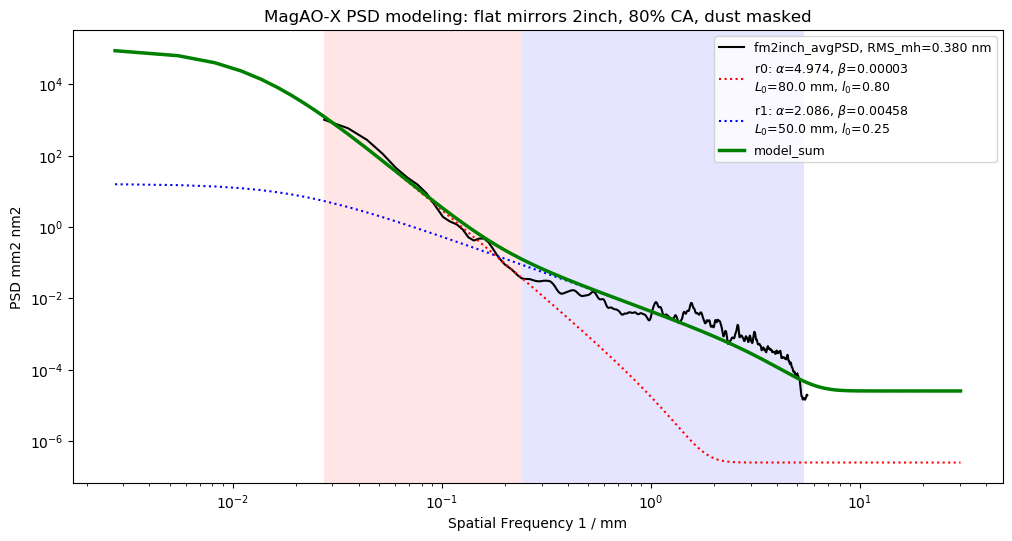

In [4]:
i_start = [0, 26] 
           #145]
i_end = i_start[1:]
i_end.append(650)

lo = [0.8, 0.25, 0.1]
L0 = [80*u.mm, 50*u.mm, 1*u.mm]
rms_sr = [0.005*u.nm, 0.05*u.nm, 0.05*u.nm]
n_high_k = 1000
k_min = np.amin(avg_psd.k_radial)
k_max = np.amax(avg_psd.k_radial)
mdl_set = []
for j in range(0, len(i_start)):
    mdl = psd.model(region_num=j, ind_start=i_start[j], ind_end=i_end[j],
                k_radial=avg_psd.k_radial, p_radial=avg_psd.psd_radial_cal,
                k_min=k_min, k_max=k_max)
    mdl.solve_lsf()
    mdl.expand_k(delta_k=avg_psd.delta_k, n_high_k=n_high_k)
    #k_min = np.amin(mdl.k_extend)
    #k_max = np.amax(mdl.k_extend)
    mdl.calc_bsr(rms_sr=rms_sr[j])
    mdl.calc_model_full(L0=L0[j], lo=lo[j], k_range=mdl.k_extend)
    if j==0: mdl_sum = mdl.model_full
    else: mdl_sum = mdl_sum + mdl.model_full
    mdl_set.append(mdl)

alpha_tone = 0.1
color_list=['r', 'b','y']
plt.figure(figsize=[12,6], dpi=100)
plt.loglog(avg_psd.k_radial.value, avg_psd.psd_radial_cal.value, 'k', label='{0}, RMS_mh={1:.3f}'.format(avg_psd.surf_name, avg_psd.rms_mh))
for j in range(0, len(i_start)):
    plt.loglog(mdl_set[j].k_extend.value, mdl_set[j].model_full.value, color_list[j]+':', linewidth=1.5,
               label='r{0}: {1}={2:.3f}, {3}={4:.5f}\n{5}={6:.1f}, {7}={8:.2f}'.format(mdl_set[j].region_num, r'$\alpha$', mdl_set[j].alpha, 
                                                                                       r'$\beta$', mdl_set[j].beta.value,
                                                                                      r'$L_{0}$',L0[j], r'$l_{0}$', lo[j]))
    plt.axvspan(avg_psd.k_radial[i_start[j]].value, avg_psd.k_radial[i_end[j]].value, 
                facecolor=color_list[j], alpha=alpha_tone)
plt.loglog(mdl_set[j].k_extend.value, mdl_sum.value, 'g', linewidth=2.5, label='model_sum')
plt.xlabel('Spatial Frequency {0}'.format(avg_psd.k_radial.unit))
plt.ylabel('PSD {0}'.format(avg_psd.psd_radial_cal.unit))
plt.title('MagAO-X PSD modeling: flat mirrors 2inch, {0}% CA, dust masked'.format(psd_parms['ca']))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))